# Импортирование библиотек и данных

Подключение к Google Диску

In [3]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_FOLDER = "/content/drive/MyDrive/Neural_Network/"


Mounted at /content/drive


Создание системы папок для правильной работы программы


In [5]:
import os

if not os.path.exists(DRIVE_FOLDER):
    os.mkdir(DRIVE_FOLDER)

if not os.path.exists(DRIVE_FOLDER + "dataset/"):
    os.mkdir(DRIVE_FOLDER + "dataset/")

if not os.path.exists(DRIVE_FOLDER + "results/"):
    os.mkdir(DRIVE_FOLDER + "results/")

if not os.path.exists(DRIVE_FOLDER + "results/confusion/"):
    os.mkdir(DRIVE_FOLDER + "results/confusion/")

if not os.path.exists(DRIVE_FOLDER + "results/confusion/color/"):
    os.mkdir(DRIVE_FOLDER + "results/confusion/color/")

if not os.path.exists(DRIVE_FOLDER + "results/confusion/grayscale/"):
    os.mkdir(DRIVE_FOLDER + "results/confusion/grayscale/")

if not os.path.exists(DRIVE_FOLDER + "results/history/"):
    os.mkdir(DRIVE_FOLDER + "results/history/")

if not os.path.exists(DRIVE_FOLDER + "results/models/"):
    os.mkdir(DRIVE_FOLDER + "results/models/")

Импортирование датасета из репозитория github в Google Диск

In [1]:
!pip install wget
!pip install zipfile
import wget
import zipfile

# импортим датасет из гитхаба
# wget.download(url, out=DRIVE_FOLDER + "dataset/")
# распаковываем h5 файл
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    # zip_ref.extractall(directory_to_extract_to)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b184bf9606fc9fe653b4043c2c85c47102e8eb51e43c314f6b1273b37e34d3ab
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Импортирование библиотек

In [2]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


Загрузка датасета из Google Диска

In [3]:
file_h5 = h5py.File(DRIVE_FOLDER + 'dataset/letters.h5')
file_csv = pd.read_csv(DRIVE_FOLDER + 'dataset/letters.csv', delimiter=',')


# Предобработка и вывод примеров данных

Вывод данных из csv файла

In [4]:
from sklearn.utils import shuffle
shuffle(file_csv).head(10)


,letter,label,file,background
9717,й,11,11_358.png,3
13870,ю,32,32_311.png,3
8790,ё,7,07_231.png,3
13104,ъ,28,28_345.png,3
520,й,11,11_21.png,0
13628,э,31,31_269.png,3
4889,р,18,18_230.png,2
4877,р,18,18_218.png,2
6977,ь,30,30_158.png,2
13211,ы,29,29_252.png,3


Нормализация данных

In [5]:
keys = list(file_h5.keys())
print(keys)


['backgrounds', 'images', 'labels']


In [6]:
backgrounds = np.array(file_h5[keys[0]])
images = np.array(file_h5[keys[1]])
labels = np.array(file_h5[keys[2]])

n = len(images)
letters = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и',
           'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т',
           'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь',
           'э', 'ю', 'я']

# Изменение размера изображений и разделение на три канала
images = images.reshape(n, 32, 32, 3)

# Деление значений цветов на 255 для перевода значений в [0, 1]
images = images / 255


Вывод данных о датасете

Общее количество изображений: 14190
Общее количество классов: 33
Максимальное количество изображений в классе: 430
Минимальное количество изображений в классе: 430



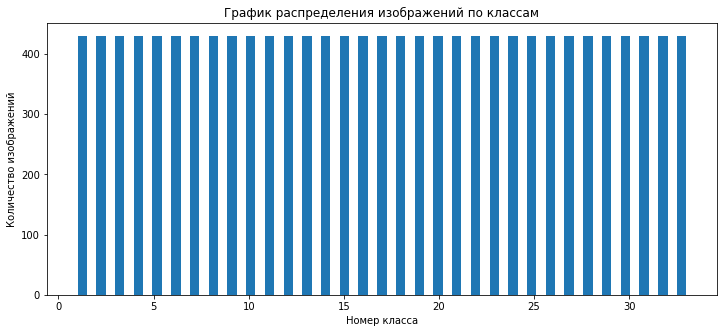

In [7]:
from collections import Counter
counted_data = Counter(labels)
data_items = counted_data.items()

print(f"Общее количество изображений: {n}")
print(f"Общее количество классов: {len(set(labels))}")
print(f"Максимальное количество изображений в классе: {max(data_items)[1]}")
print(f"Минимальное количество изображений в классе: {min(data_items)[1]}\n")

# Вывод графика
fig, ax = plt.subplots(figsize=(12, 5))
plt.title("График распределения изображений по классам")
ax.set_xlabel('Номер класса')
ax.set_ylabel('Количество изображений')
plt.hist(labels, 65)
plt.show()


Вывод примеров изображений

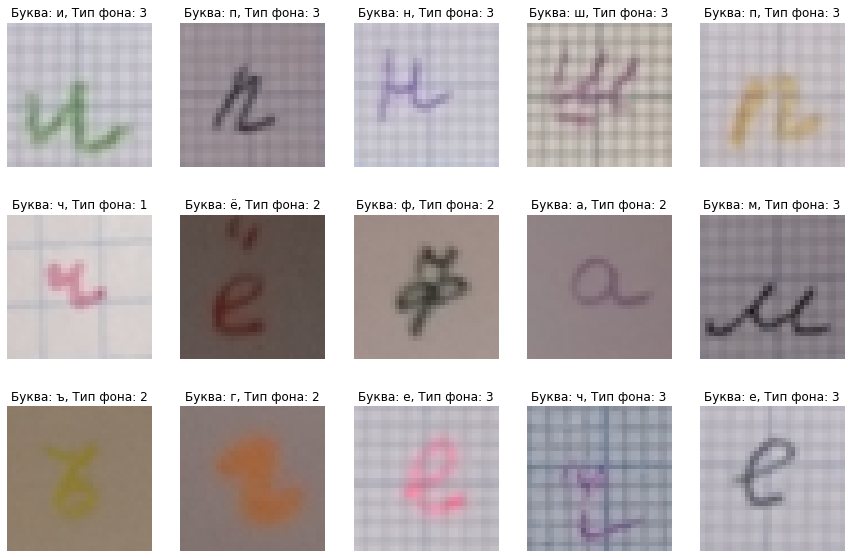

In [8]:
from random import sample

rows = 3  # Количество строк в таблице
columns = 5  # Количество столбцов в таблице

numbers = sample(range(n), rows * columns)

fig = plt.figure(figsize=(15, 10))

for i in range(len(numbers)):
    fig.add_subplot(rows, columns, i + 1)
    plt.title("Буква: {label}, Тип фона: {background}".format(
        label=letters[labels[numbers[i]] - 1],
        background=backgrounds[numbers[i]]))
    plt.axis('off')
    plt.imshow(images[numbers[i]])

plt.show()


# Разработка и обучение нейронной сети

In [9]:
import tensorflow as tf
import random as rnd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


Настройка данных для обучения и тестирования

In [10]:
y = OneHotEncoder(categories='auto')
y = y.fit_transform(labels.reshape(-1, 1)).toarray().astype('int64')
x = images
random_state = rnd.randint(0, 1000)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=random_state)


In [11]:
print(f"Объем данных для обучения: {len(x_train)}")
print(f"Объем данных для тестирования: {len(x_test)}")


Объем данных для обучения: 11352
Объем данных для тестирования: 2838


Загрузка обученной модели (в случае надобности)

In [12]:
# name = "0.857"

# model = tf.keras.models.load_model(DRIVE_FOLDER + f"results/models/{name}")
# history = pd.read_json(DRIVE_FOLDER + f"results/history/{name}.json")
# # history = pd.read_csv(DRIVE_FOLDER + f"results/history/{name}.csv")

# hist = history

Создание архитектуры нейронной сети

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)


def sequential_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(32, 32, 3)))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))

    model.add(Conv2D(128, kernel_size=(4, 4),
                     activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(set(labels)), activation='softmax'))

    return model

model = sequential_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 128)       0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                        

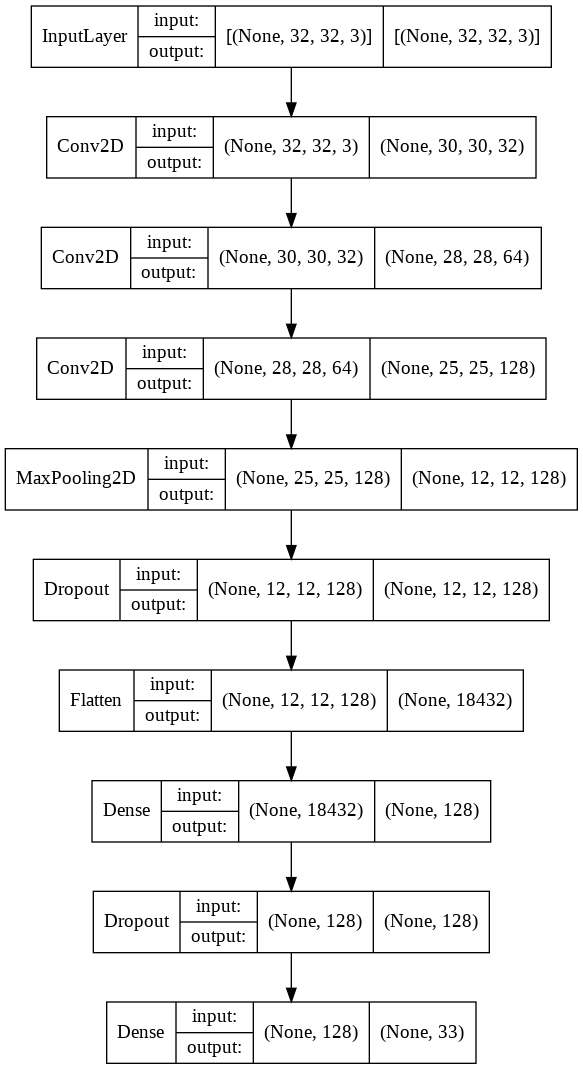

In [14]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)


Обучение модели


In [15]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
)

checkpointer = ModelCheckpoint(filepath=DRIVE_FOLDER + 'results/best_weights.hdf5',
                               verbose=5,
                               monitor='val_accuracy',
                               save_best_only=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=5,
                                 verbose=2,
                                 factor=.75)

estopping = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=2)

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=200,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer, lr_reduction, estopping])

hist = history.history


Epoch 1/200
178/178 [==============================] - ETA: 0s - loss: 3.3587 - accuracy: 0.0712
Epoch 1: val_accuracy improved from -inf to 0.20684, saving model to /content/drive/MyDrive/Neural_Network/results/best_weights.hdf5
178/178 [==============================] - 15s 21ms/step - loss: 3.3587 - accuracy: 0.0712 - val_loss: 2.8786 - val_accuracy: 0.2068 - lr: 0.0010
Epoch 2/200
177/178 [============================>.] - ETA: 0s - loss: 2.5419 - accuracy: 0.2872
Epoch 2: val_accuracy improved from 0.20684 to 0.44151, saving model to /content/drive/MyDrive/Neural_Network/results/best_weights.hdf5
178/178 [==============================] - 2s 14ms/step - loss: 2.5424 - accuracy: 0.2869 - val_loss: 2.0522 - val_accuracy: 0.4415 - lr: 0.0010
Epoch 3/200
177/178 [============================>.] - ETA: 0s - loss: 1.8906 - accuracy: 0.4545
Epoch 3: val_accuracy improved from 0.44151 to 0.59690, saving model to /content/drive/MyDrive/Neural_Network/results/best_weights.hdf5
178/178 [====

Вывод графиков потерь, точности и скорости обучения

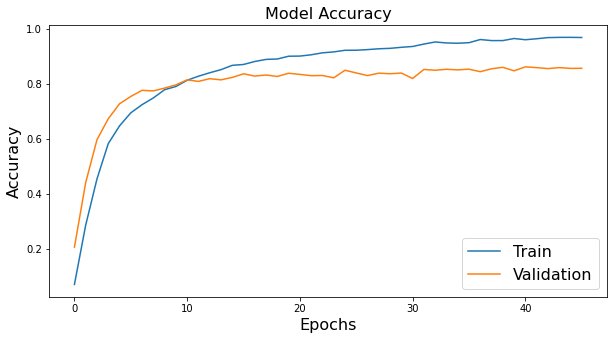

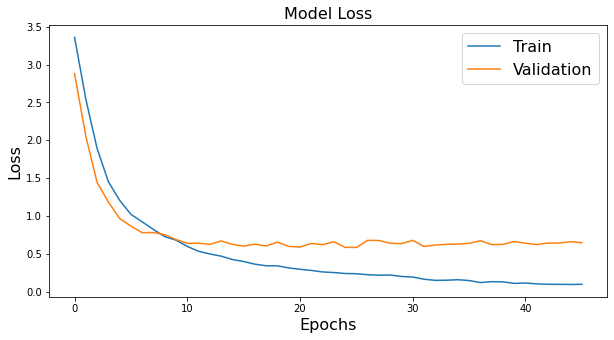

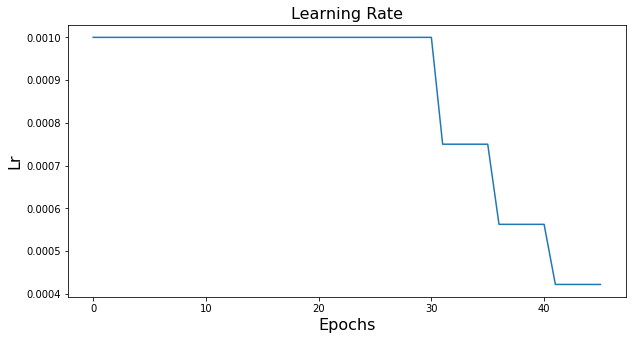

In [16]:
fig = plt.figure(figsize=(10, 5))
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.legend(['Train', 'Validation'], fontsize=16)

fig = plt.figure(figsize=(10, 5))
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.legend(['Train', 'Validation'], fontsize=16)
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(hist['lr'])
plt.title('Learning Rate', fontsize=16)
plt.ylabel('Lr', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.show()


In [17]:
import seaborn as sb
import string

# Получение общей матрицы путаницы
def confusion_matrix(model, x_test=x_test, y_test=y_test):
    labels_count = len(set(letters))
    matrix = np.zeros((labels_count, labels_count))

    for i in range(len(x_test)):
        model_prediction = model.predict(x_test[i].reshape(1, 32, 32, 3))
        matrix[tf.argmax(y_test[i]),
               tf.argmax(tf.round(model_prediction)[0])] += 1

    return matrix


def draw_matrix(matrix, size, save_path: str, name: str = None, 
                title: str=None, title_size: int=12, 
                labels_x=None, labels_y=None, labels_size: int=12,
                labels_x_rotation: int=0, labels_y_rotation: int=0,
                annot_size:int=12, mask=None, line=0., cmap="hot",
                line_color="black"):
    vmax = np.max(matrix)

    if vmax < 1:
        vmax = 1

    plt.figure(figsize=(size))

    if title is not None:
        plt.title(title, fontsize=title_size)

    if name is None:
        if title is None:
            name = "".join([rnd.choice(string.letters) for i in range(15)])
        else:
            name = title

    ax = sb.heatmap(matrix, annot=True, vmin=0, vmax=vmax, mask=mask,
                    fmt='.5g', cmap=cmap, linewidths=line,
                    linecolor=line_color, annot_kws={"fontsize": annot_size})

    if labels_x is not None:
        ax.set_xticklabels(labels_x, fontsize=labels_size,
                           rotation=labels_x_rotation,
                           horizontalalignment='center')

    if labels_y is not None:
        ax.set_yticklabels(labels_y, fontsize=labels_size,
                           rotation=labels_y_rotation,
                           verticalalignment='center')

    plt.savefig(DRIVE_FOLDER + save_path + f"{name}.png")
    plt.show()


# Вычисление TP FN FP TN


# TruePositive
def get_TP(matrix):
    return np.diag(matrix)


def get_norm_TP(matrix):
    return get_TP(matrix) / np.sum(matrix[0])


# FalseNegative
def get_FN(matrix):
    FalseNegative = []

    for i in range(len(matrix)):
        FalseNegative.append(np.sum(matrix[i]) - matrix[i, i])

    return FalseNegative


def get_norm_FN(matrix):
    return get_FN(matrix) / np.sum(matrix[0])


# FalsePositive
def get_FP(matrix):
    FalsePositive = []

    for i in range(len(matrix)):
        FalsePositive.append(np.sum(matrix[:, i]) - matrix[i, i])

    return FalsePositive


def get_norm_FP(matrix):
    return get_FP(matrix) / np.sum(matrix)


# TrueNegative
def get_TN(matrix):
    TP = get_TP(matrix)
    FN = get_FN(matrix)
    FP = get_FP(matrix)
    sum = np.sum(matrix)

    TrueNegative = []

    for i in range(len(matrix)):
        TrueNegative.append(sum - TP[i] - FN[i] - FP[i])

    return TrueNegative


def get_norm_TN(matrix):
    return get_TN(matrix) / np.sum(matrix)


# Получение матриц путаницы для отдельных классов
def confusion_matrix_i(TP, FP, FN, TN, count):
    confusion_matrix = []

    for i in range(count):
        confusion_matrix.append([[TP[i], FN[i]], [FP[i], TN[i]]])

    return np.array(confusion_matrix)


In [ ]:
matrix = confusion_matrix(model)


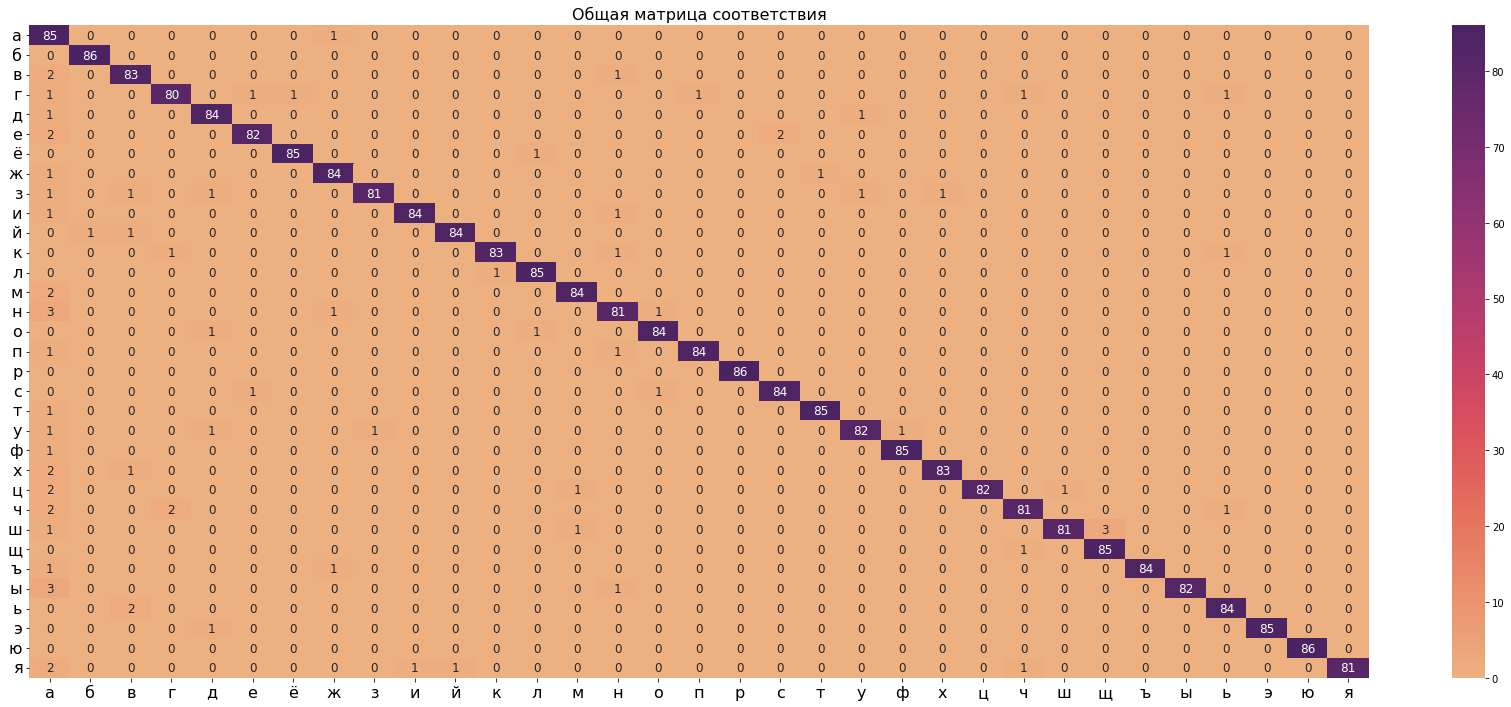

In [ ]:
draw_matrix(matrix=(matrix), size=(30, 12),
            save_path="results/confusion/",
            labels_x=letters, labels_y=letters, cmap="flare",
            title="Общая матрица соответствия", title_size=16, labels_size=16)

In [ ]:
TP = get_norm_TP(matrix)
FN = get_norm_FN(matrix)
FP = get_norm_FP(matrix)
TN = get_norm_TN(matrix)

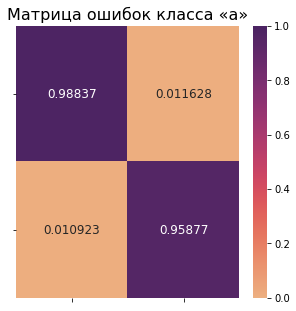

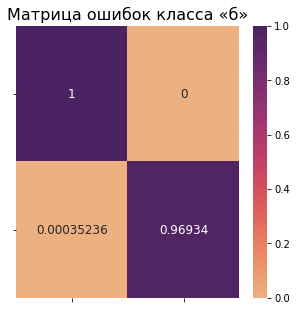

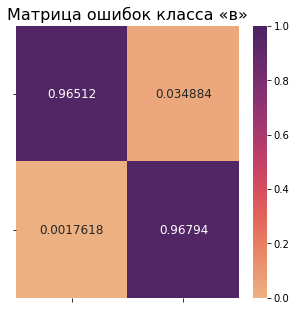

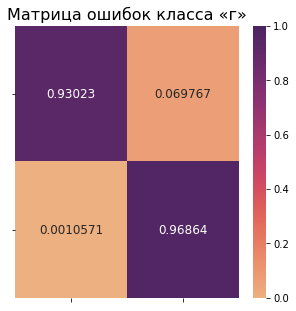

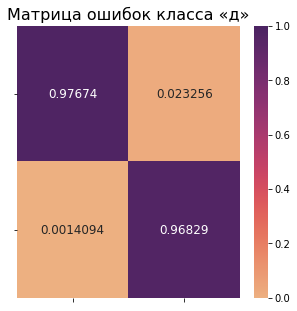

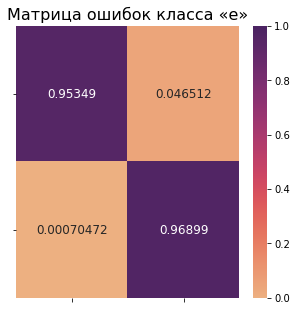

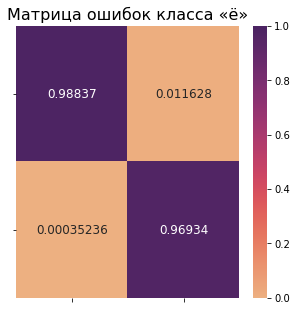

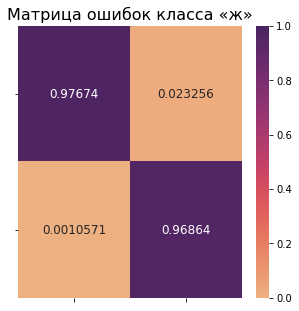

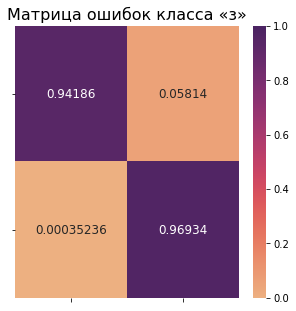

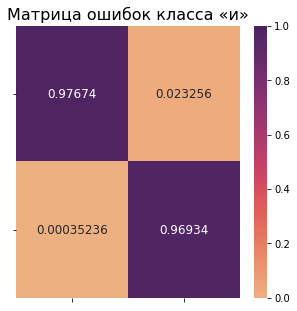

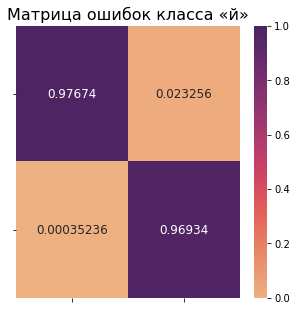

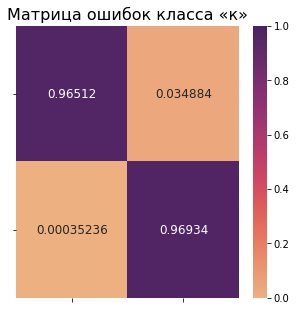

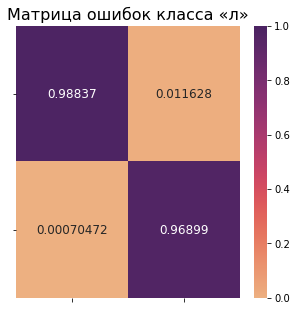

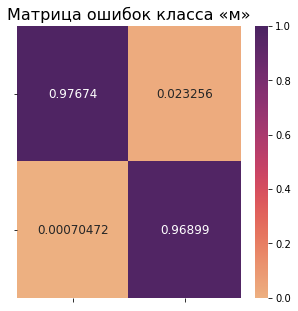

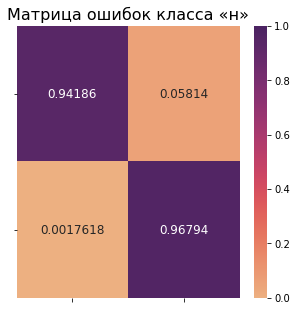

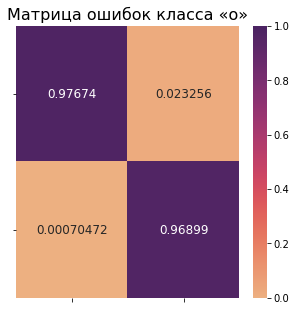

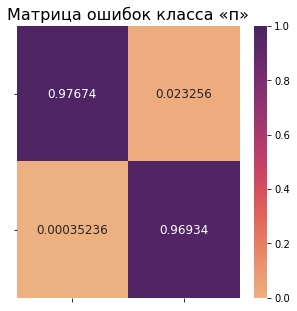

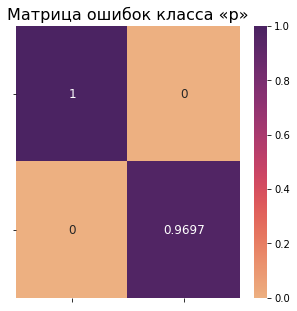

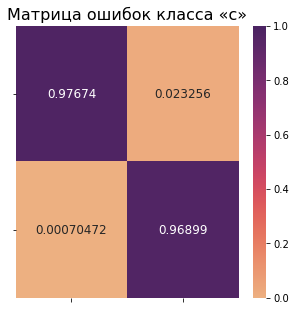

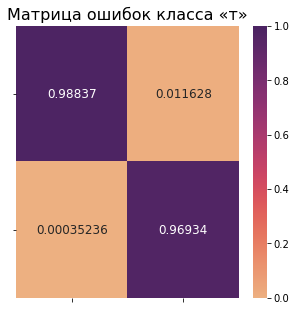

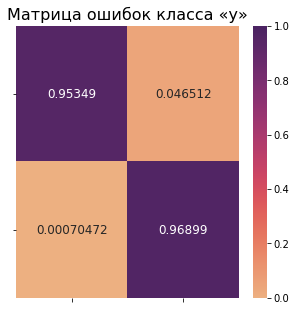

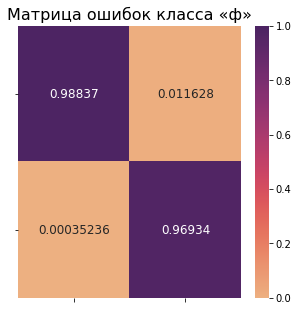

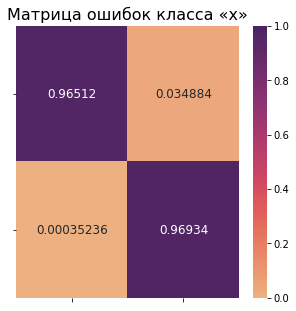

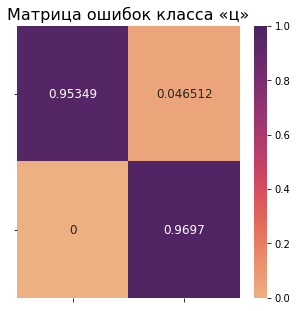

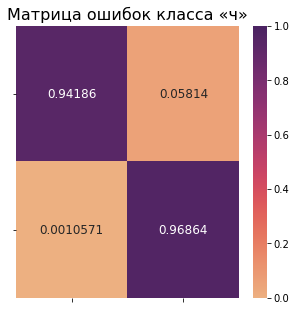

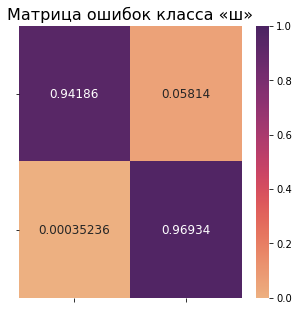

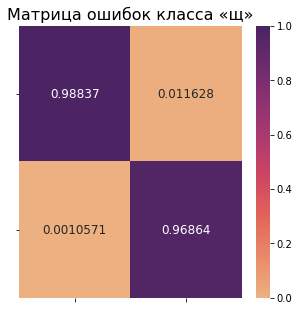

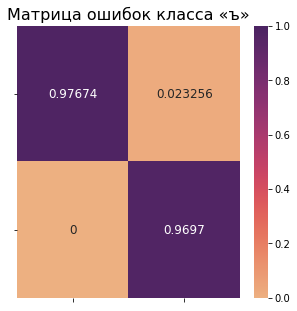

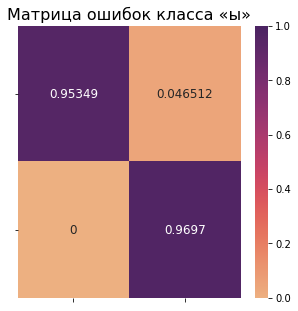

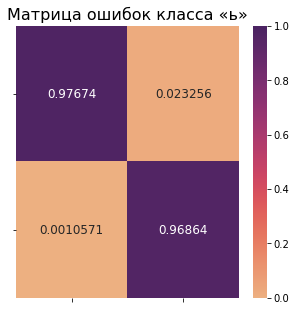

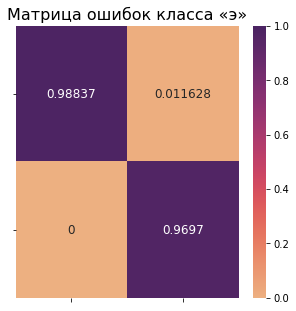

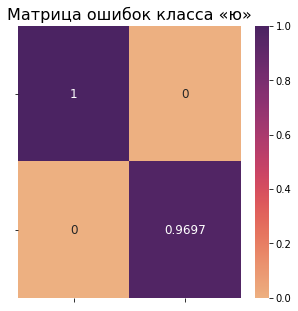

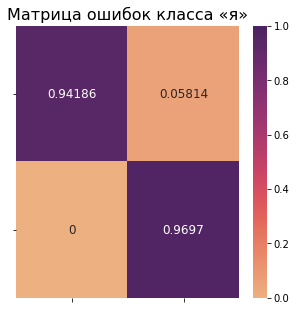

In [ ]:
CM = confusion_matrix_i(TP, FP, FN, TN, len(TP))

for i in range(len(CM)):
    draw_matrix(CM[i], size=(5, 5),
                save_path="results/confusion/grayscale/",
                title=f"Матрица ошибок класса «{letters[i]}»", cmap="flare",
                labels_x="", labels_y="",
                title_size=16)

In [ ]:
_TP = sum(get_TP(matrix))
_FN = sum(get_FN(matrix))
_FP = sum(get_FP(matrix))
_TN = sum(get_TN(matrix))

prec = _TP / (_TP + _FP)
sens = _TP / (_TP + _FN)
spec = _TN / (_TN + _FP)
acc = (_TP + _TN) / (_TP + _FN + _FP + _TN)
neg = _TN / (_TN + _FN)
print(f"Precision: {prec}")
print(f"Sensitivity: {sens}")
print(f"Specitivity: {spec}")
print(f"Negative Predictive Value: {neg}")
print(f"Accuracy: {acc}")

Precision: 0.9619450317124736
Sensitivity: 0.9619450317124736
Specitivity: 0.9988107822410148
Negative Predictive Value: 0.9988107822410148
Accuracy: 0.9976936382856044


# Сохранение результатов

In [18]:
acc = str(history.history['val_accuracy'][-1])[0:5]


def save_history(hist, as_json : bool, as_csv : bool):
    hist_df = pd.DataFrame(hist.history)
    if (as_json):
        with open(DRIVE_FOLDER + f"results/history/{acc}.json", mode='w') as f:
            hist_df.to_json(f)
            f.close()

    if (as_csv):
        hist_csv_file = 'history.csv'
        with open(DRIVE_FOLDER + f"results/history/{acc}.csv", mode='w') as f:
            hist_df.to_csv(f)
            f.close()


Сохранение истории обучения модели

In [19]:
save_history(history, True, True)


Сохранение весов модели

In [ ]:
model.save_weights(DRIVE_FOLDER + f'results/NWW_{acc}.hdf5')


Сохранение всей модели

In [ ]:
model.save(DRIVE_FOLDER + f"results/models/{acc}")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Neural_Network/results/models/0.9978858350951374/assets


# Черновик

Вывод примеров распознавания изображений

In [ ]:
def get_test_table(model, plotsize, x_test=x_test, y_test=y_test,
                   table_size: int=1, rows: int=1, cols: int=1):
    nums = np.random.randint(low=0, high=len(x_test), size=table_size)
    answers = np.empty([table_size])

    for i in range(table_size):
        model_prediction = model.predict(x_test[nums[i]].reshape(1, 32, 32, 3))
        answers[i] = tf.argmax(tf.round(model_prediction)[0])

    fig = plt.figure(figsize=plotsize)
    for i in range(len(answers)):
        fig.add_subplot(rows, cols, i + 1)
        letter_x = letters[int(answers[i])]
        letter_y = letters[tf.argmax(y_test[nums[i]])]
        plt.title(f"На картинке:{letter_y}\nРаспознано: {letter_x}")
        plt.axis('off')
        plt.imshow(x_test[nums[i]])

    plt.show()


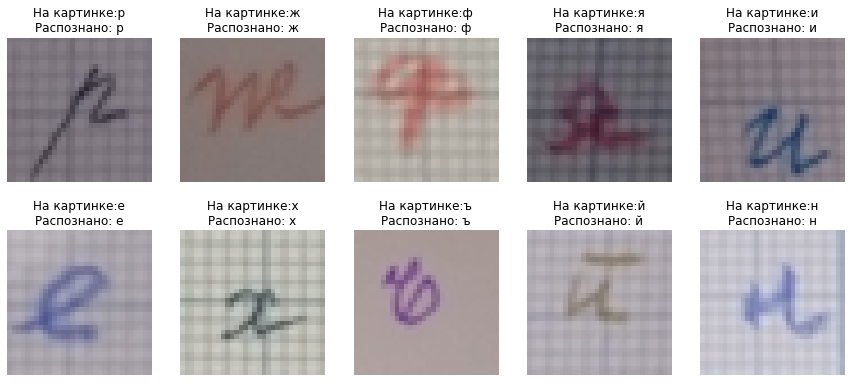

In [ ]:
get_test_table(model, plotsize=(15, 6.5), table_size=10, rows=2, cols=5)

Вывод архитектуры модели для датасета MNIST

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def numerical_model():
    model = Sequential()
    model.add(Dense(784, activation='relu', input_shape=(392, 392)))
    model.add(Dense(800, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

model = numerical_model()
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 392, 784)          308112    
                                                                 
 dense_1 (Dense)             (None, 392, 800)          628000    
                                                                 
 dense_2 (Dense)             (None, 392, 10)           8010      
                                                                 
Total params: 944,122
Trainable params: 944,122
Non-trainable params: 0
_________________________________________________________________


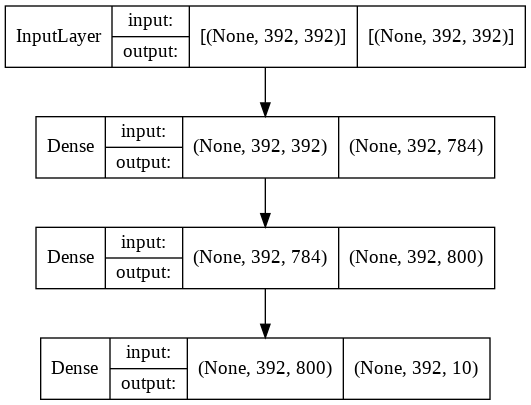

In [ ]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)


Вывод графиков функций активации

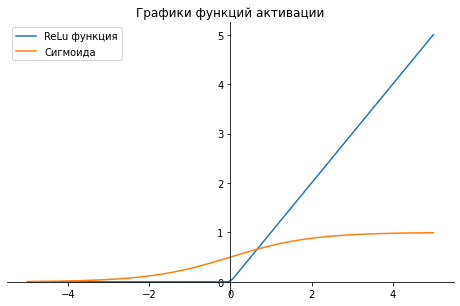

In [ ]:
import math
x = np.linspace(-5, 5, 100)
y_r = np.empty([100])
y_s = np.empty([100])


def ReLu(x):
    if x > 0: return x
    else: return 0


def sigmoid(x):
    return 1/(1 + math.exp(-x))


for i in range(len(x)):
    y_r[i] = ReLu(x[i])
    y_s[i] = sigmoid(x[i])

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot(x, y_r)
plt.plot(x, y_s)
plt.title('Графики функций активации')
# fontsize=16
plt.legend(['ReLu функция', 'Сигмоида'])
plt.show()
